# Complete Guide To Web Scraping Using Firecrawl's Scrape Endpoint

## Introduction

Traditional web scraping offers unique challenges. Relevant information is often scattered across multiple pages containing complex elements like code blocks, iframes, and media. JavaScript-heavy websites and authentication requirements add additional complexity to the scraping process.

Even after successfully scraping, the content requires specific formatting to be useful for downstream processes like data engineering or training AI and machine learning models. 

Firecrawl addresses these challenges by providing a specialized scraping solution. Its `/scrape` endpoint offers features like JavaScript rendering, automatic content extraction, bypassing blockers and flexible output formats that make it easier to collect high-quality information and training data at scale.

In this guide, we'll explore how to effectively use Firecrawl's `/scrape`  endpoint to extract structured data from static and dynamic websites. {prompt: finish this paragraph based on the table of contents I have}


## Prerequisites


Firecrawl's scraping engine is exposed as a REST API, so you can use command-line tools like cURL to use it. However, for a more comfortable experience, better flexibility and control, I recommend using one of its SDKs for Python, Node, Rust or Go. This tutorial will focus on the Python version.

To get started, please make sure to:

1. Sign up at [firecrawl.dev]().
2. Choose a plan (the free one will work fine for this tutorial).

Once you sign up, you will be given an API token or you can copy it from your [dashboard](https://www.firecrawl.dev/app). The best way to save your key is by using a `.env` file, ideal for the purposes of this article:

```bash
$ touch .env
$ echo "FIRECRAWL_API_KEY='YOUR_API_KEY'" >> .env
```

Now, let's install Firecrawl Python SDK, `python-dotenv` to read `.env` files, and {add other packages used in the rest of the tutorial}:


```bash
$ pip install firecrawl-py python-dotenv {other-packages-used}
```

## Basic Scraping Setup

Scraping with Firecrawl starts by creating an instance of the `FirecrawlApp` class:

In [2]:
from firecrawl import FirecrawlApp
from dotenv import load_dotenv

load_dotenv()

app = FirecrawlApp()


When you use the `load_dotenv()` function, the app can automatically use your loaded API key to establish a connection with the scraping engine. Then, scraping any URL takes a single line of code:

In [38]:
url = "https://arxiv.org"
data = app.scrape_url(url)


Let's take a look at the response format returned by `scrape_url` method:

In [39]:
data['metadata']

{'title': 'arXiv.org e-Print archiveopen searchopen navigation menucontact arXivsubscribe to arXiv mailings',
 'language': 'en',
 'ogLocaleAlternate': [],
 'viewport': 'width=device-width, initial-scale=1',
 'msapplication-TileColor': '#da532c',
 'theme-color': '#ffffff',
 'sourceURL': 'https://arxiv.org',
 'url': 'https://arxiv.org/',
 'statusCode': 200}

The response `metadata` includes basic information like the page title, viewport settings and a status code. 

Now, let's look at the scraped contents, which is converted into `markdown` by default:

In [45]:
from IPython.display import Markdown

Markdown(data['markdown'][:500])


arXiv is a free distribution service and an open-access archive for nearly 2.4 million
scholarly articles in the fields of physics, mathematics, computer science, quantitative biology, quantitative finance, statistics, electrical engineering and systems science, and economics.
Materials on this site are not peer-reviewed by arXiv.


Subject search and browse:

Physics

Mathematics

Quantitative Biology

Computer Science

Quantitative Finance

Statistics

Electrical Engineering and Systems Scienc

The response can include several other formats that we can request when scraping a URL. Let's try requesting multiple formats at once to see what additional data we can get back:

In [46]:
data = app.scrape_url(
    url, 
    params={
        'formats': [
            'html', 
            'rawHtml', 
            'links', 
            'screenshot',
        ]
    }
)

Here is what these formats scrape:

 - **HTML**: The raw HTML content of the page.
 - **rawHtml**: The unprocessed HTML content, exactly as it appears on the page.
 - **links**: A list of all the hyperlinks found on the page.
 - **screenshot**: An image capture of the page as it appears in a browser.

The HTML format is useful for developers who need to analyze or manipulate the raw structure of a webpage. The `rawHtml` format is ideal for cases where the exact original HTML content is required, such as for archival purposes or detailed comparison. The links format is beneficial for SEO specialists and web crawlers who need to extract and analyze all hyperlinks on a page. The screenshot format is perfect for visual documentation, quality assurance, and capturing the appearance of a webpage at a specific point in time.

Passing more than one scraping format to `params` adds additional keys to the response:

In [47]:
data.keys()

dict_keys(['rawHtml', 'screenshot', 'metadata', 'html', 'links'])

Let's display the screenshot Firecrawl took of arXiv.org:

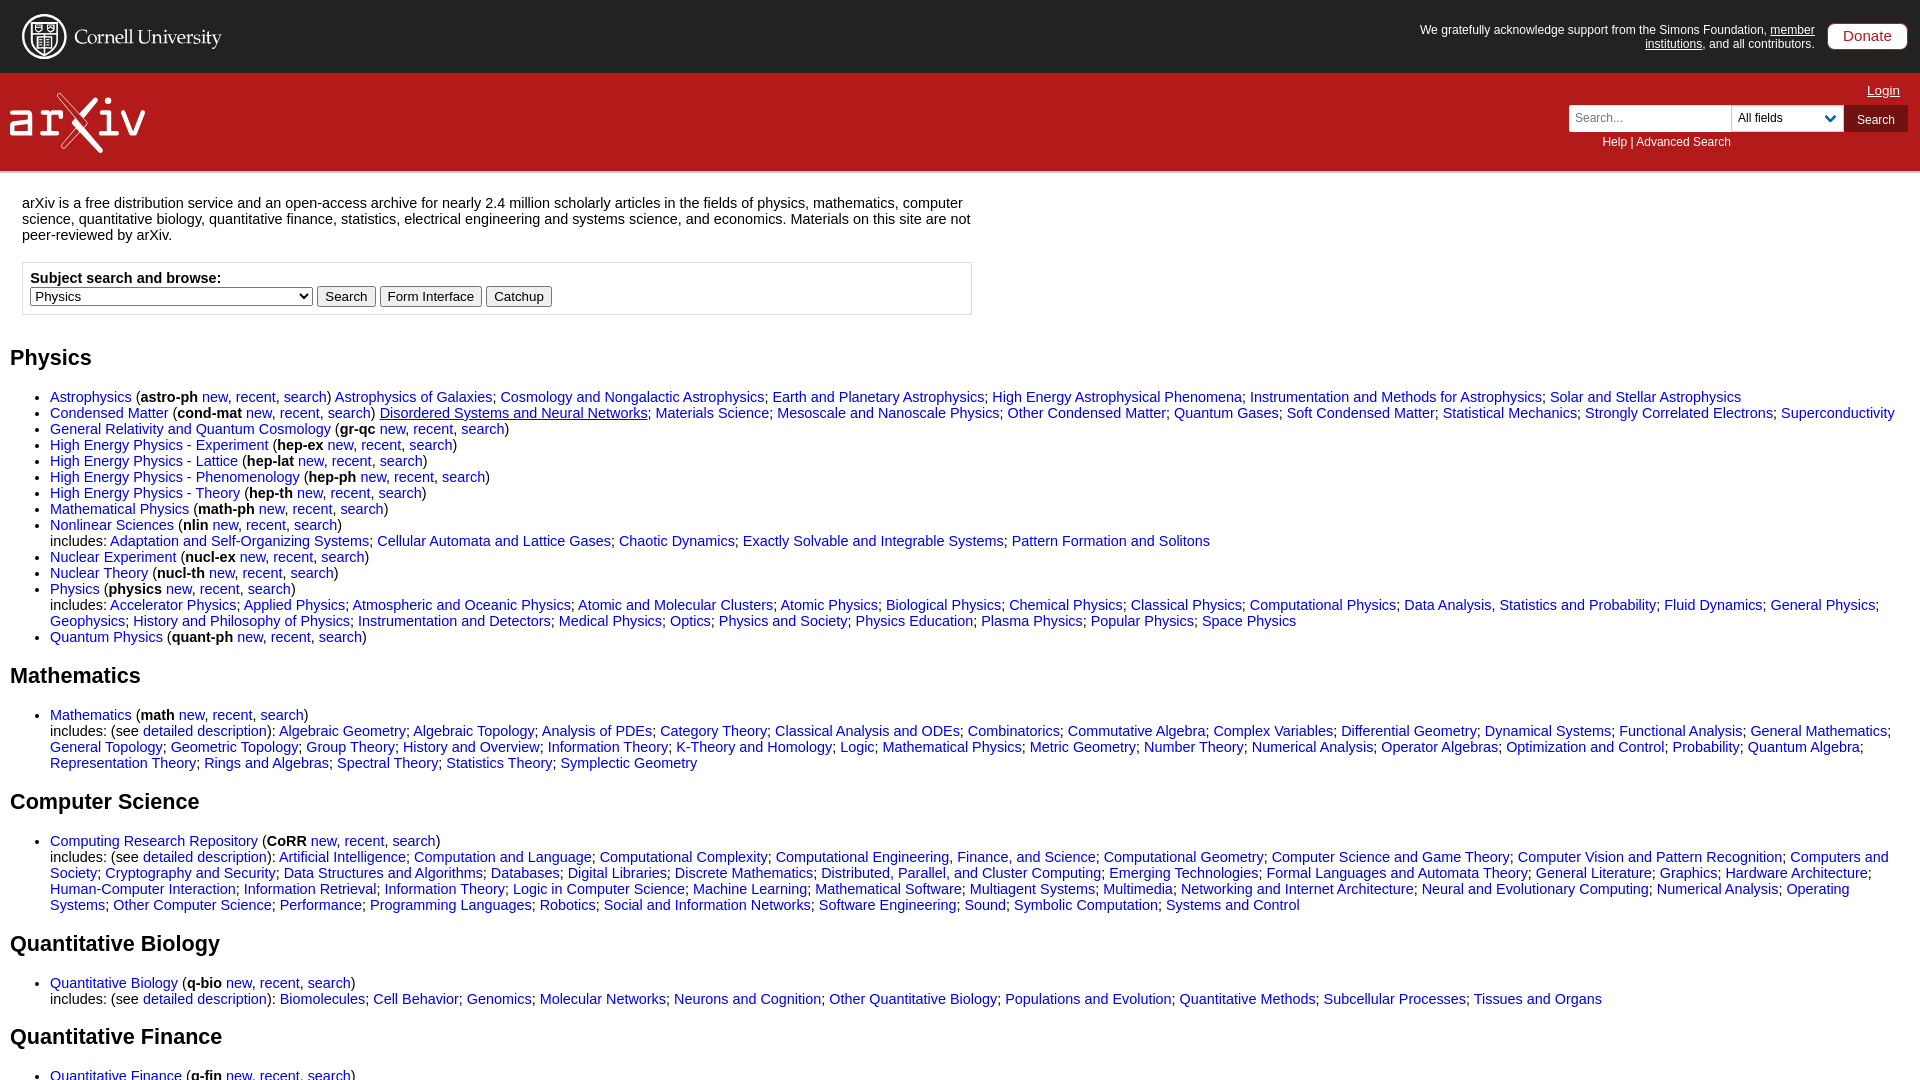

In [48]:
from IPython.display import Image

Image(data['screenshot'])

Notice how the screenshot is cropped to fit a certain viewport. For most pages, it is better to capture the entire screen by using the `screenshot@fullPage` format:

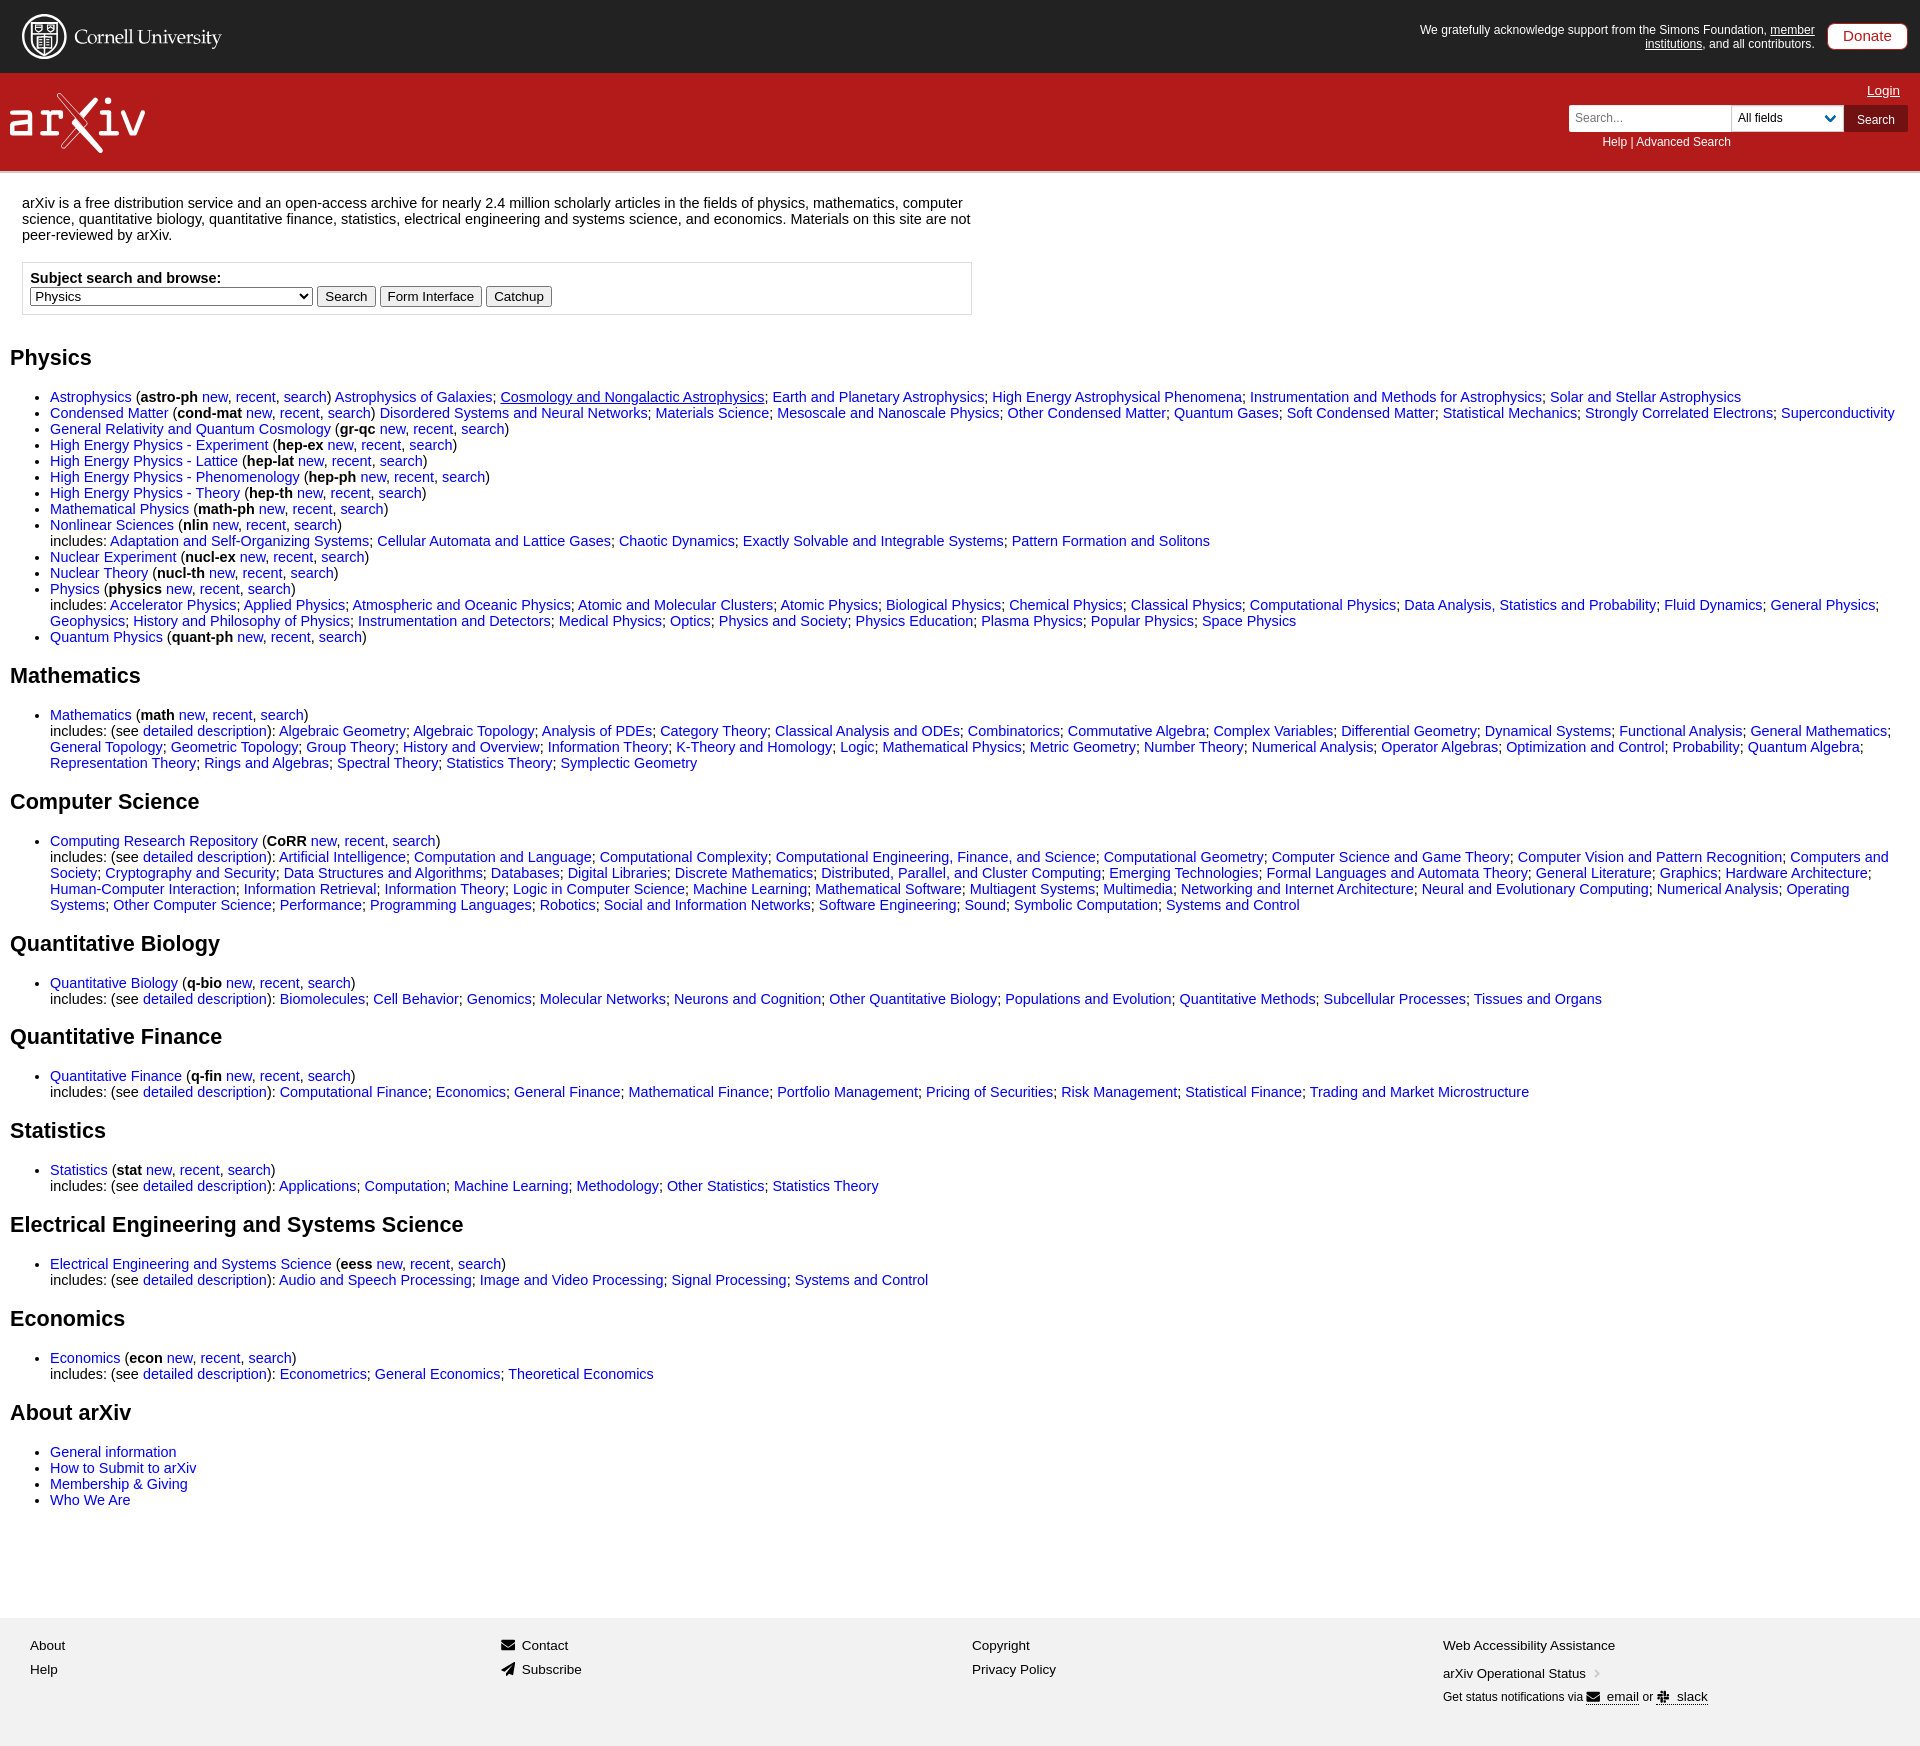

In [52]:
data = app.scrape_url(
    url,
    params={
        "formats": [
            "screenshot@fullPage",
        ]
    }
)

Image(data['screenshot'])

As a bonus, the `/scrape` endpoint can handle PDF links as well:

In [51]:
pdf_link = "https://arxiv.org/pdf/2411.09833.pdf"
data = app.scrape_url(pdf_link)

Markdown(data['markdown'][:500])

arXiv:2411.09833v1 \[math.DG\] 14 Nov 2024
EINSTEIN METRICS ON THE FULL FLAG F(N).
MIKHAIL R. GUZMAN
Abstract.LetM=G/Kbe a full flag manifold. In this work, we investigate theG-
stability of Einstein metrics onMand analyze their stability types, including coindices,
for several cases. We specifically focus onF(n) = SU(n)/T, emphasizingn= 5, where
we identify four new Einstein metrics in addition to known ones. Stability data, including
coindex and Hessian spectrum, confirms that these metrics on

### Further Configuration Options

By default, `scrape_url` converts everything it sees on a webpage to one of the specified formats. To control this behavior, Firecrawl offers the following parameters:
- `onlyMainContent`
- `includeTags`
- `excludeTags`

`onlyMainContent` excludes the navigation, footers, headers, etc. and is set to True by default. 

`includeTags` and `excludeTags` can be used to whitelist/blacklist certain HTML elements:

In [62]:
url = "https://arxiv.org"

data = app.scrape_url(url, params={"includeTags": ["p"], "excludeTags": ["span"]})

Markdown(data['markdown'][:1000])

[Help](https://info.arxiv.org/help) \| [Advanced Search](https://arxiv.org/search/advanced)

arXiv is a free distribution service and an open-access archive for nearly 2.4 million
scholarly articles in the fields of physics, mathematics, computer science, quantitative biology, quantitative finance, statistics, electrical engineering and systems science, and economics.
Materials on this site are not peer-reviewed by arXiv.


[arXiv Operational Status](https://status.arxiv.org)

Get status notifications via
[email](https://subscribe.sorryapp.com/24846f03/email/new)
or [slack](https://subscribe.sorryapp.com/24846f03/slack/new)

`includeTags` and `excludeTags` also support referring to HTML elements by their `#id` or `.class-name`. 

##  Structured Data Extraction

Scraping clean, LLM-ready data is the core philosophy of Firecrawl. However, certain web pages with their complex structures can interfere with this philosophy when scraped in their entirety. For this reason, Firecrawl offers two scraping methods for better structured outputs:

1. Natural language extraction - Use prompts to extract specific information and have an LLM structure the response
2. Manual structured data extraction - Define JSON schemas to have an LLM scrape data in a predefined format

In this section, we will cover both methods.

### Scraping using natural language

To illustrate natural language scraping, let's try extracting all news article links that may be related to the 2024 US presidential election from the New York Times:

In [97]:
url = "https://nytimes.com"

data = app.scrape_url(
    url,
    params={
        'formats': ['markdown', 'extract', 'screenshot'],
        'extract': {
            'prompt': "Return a list of links of news articles that may be about the 2024 US presidential election"
        }
    }
)

To enable this feature, you are required to pass the `extract` option to the list of `formats` and provide a prompt in a dictionary to a separate `extract` key.

Once scraping finishes, the response will include a new `extract` key:

In [99]:
data['extract']

{'news_articles': [{'title': 'Harris Loss Has Democrats Fighting Over How to Talk About Transgender Rights',
   'link': 'https://www.nytimes.com/2024/11/20/us/politics/presidential-campaign-transgender-rights.html'},
  {'title': 'As Democrats Question How to Win Back Latinos, Ruben Gallego Offers Answers',
   'link': 'https://www.nytimes.com/2024/11/20/us/politics/ruben-gallego-arizona-latino-voters-democrats.html'},
  {'title': 'A Key to Trump’s Win: Heavy Losses for Harris Across the Map',
   'link': 'https://www.nytimes.com/interactive/2024/11/19/us/politics/voter-turnout-election-trump-harris.html'},
  {'title': 'Trump Promises Clean Water. Will He Clean Up ‘Forever Chemicals’?',
   'link': 'https://www.nytimes.com/2024/11/20/climate/trump-pfas-lead-clean-water.html'},
  {'title': 'Two Apartment Buildings Were Planned. Only One Went Up. What Happened?',
   'link': 'https://www.nytimes.com/interactive/2024/11/19/nyregion/affordable-housing-nyc-rent.html'},
  {'title': 'Trump Selects

Due to the nature of this scraping method, the returned output can have arbitrary structure as we can see above. It seems the above output has the following format:

```python
{
    "news_articles": [
        {"title": "article_title", "link": "article_url"},
        ...
    ]
}
```

This LLM-based extraction can have endless applications, from extracting specific data points from complex websites to analyzing sentiment across multiple news sources to gathering structured information from unstructured web content.

To improve the accuracy of the extraction and give additional instructions, you have the option to include a system prompt to the underlying LLM:

In [76]:
data = app.scrape_url(
    url,
    params={
        'formats': ['markdown', 'extract'],
        'extract': {
            'prompt': "Find any mentions of specific dollar amounts or financial figures and return them with their context and article link.",
            'systemPrompt': "You are a helpful assistant that extracts numerical financial data"
        }
    }
)

Above, we are dictating that the LLM must act as an assistant that extracts numerical financial data. Let's look at its response:

In [77]:
data['extract']

{'financial_data': [{'amount': 121200000,
   'context': 'René Magritte became the 16th artist whose work broke the nine-figure threshold at auction when his painting sold for $121.2 million.',
   'article_link': 'https://www.nytimes.com/2024/11/19/arts/design/magritte-surrealism-christies-auction.html'},
  {'amount': 5000000,
   'context': 'Benjamin Netanyahu offers $5 million for each hostage freed in Gaza.',
   'article_link': 'https://www.nytimes.com/2024/11/19/world/middleeast/israel-5-million-dollars-hostage.html'}]}

The output shows the LLM successfully extracted two financial data points from the articles.

The LLM not only identified the specific amounts but also provided relevant context and source article links for each figure.

### Scraping with a predefined schema

While natural language scraping is powerful for exploration and prototyping, production systems typically require more structured and deterministic approaches. LLM responses can vary between runs of the same prompt, making the output format inconsistent and difficult to reliably parse in automated workflows.

For this reason, Firecrawl allows you to pass a predefined schema to guide the LLM's output when transforming the scraped content. To facilitate this feature, Firecrawl uses Pydantic models. 

In the example below, instead of extracting the entire NY Times homepage, we will extract only news article links, their titles with some additional details:

In [124]:
from pydantic import BaseModel, Field

class IndividualArticle(BaseModel):
    title: str = Field(description="The title of the news article")
    subtitle: str = Field(description="The subtitle of the news article")
    url: str = Field(description="The URL of the news article")
    author: str = Field(description="The author of the news article")
    date: str = Field(description="The date the news article was published")
    read_duration: int = Field(description="The estimated time it takes to read the news article")
    topics: list[str] = Field(description="A list of topics the news article is about")

class NewsArticlesSchema(BaseModel):
    news_articles: list[IndividualArticle] = Field(
        description="A list of news articles extracted from the page"
    )

Above, we define a Pydantic schema that specifies the structure of the data we want to extract. The schema consists of two models:

`IndividualArticle` defines the structure for individual news articles with fields for:
- `title`: The article headline
- `subtitle`: Secondary headline text
- `url`: Link to the full article
- `author`: Article writer's name
- `date`: Publication date
- `read_duration`: Estimated reading time in minutes
- `topics`: List of article subject categories

`NewsArticlesSchema` acts as a container model that holds a list of `IndividualArticle` objects, representing multiple articles extracted from the page. If we don't use this container model, Firecrawl will only return the first news article it finds.

Each model field uses Pydantic's `Field` class to provide descriptions that help guide the LLM in correctly identifying and extracting the requested data. This structured approach ensures consistent output formatting.

The next step is passing this schema to the `extract` parameter of `scrape_url`:

In [125]:
url = "https://nytimes.com"

structured_data = app.scrape_url(
    url,
    params={
        "formats": ["extract", "screenshot"],
        "extract": {
            "schema": NewsArticlesSchema.model_json_schema(),
            "prompt": "Extract the following data from the NY Times homepage: news article title, url, author, date, read_duration for all news articles",
            "systemPrompt": "You are a helpful assistant that extracts news article data from NY Times.",
        },
    },
)

While passing the schema, we call its `model_json_schema()` method to automatically convert it to valid JSON. Let's look at the output:

In [126]:
structured_data['extract']

{'news_articles': [{'title': 'How Google Spent 15 Years Creating a Culture of Concealment',
   'subtitle': '',
   'url': 'https://www.nytimes.com/2024/11/20/technology/google-antitrust-employee-messages.html',
   'author': 'David Streitfeld',
   'date': '2024-11-20',
   'read_duration': 9,
   'topics': []},
  {'title': 'World Leaders Seek Stability With China as President Biden Exits the Stage',
   'subtitle': '',
   'url': 'https://www.nytimes.com/2024/11/20/us/politics/trump-world-leaders-china-xi-stability.html',
   'author': '',
   'date': '2024-11-20',
   'read_duration': 5,
   'topics': []},
  {'title': 'Linda McMahon Is Chosen by Trump to Be Education Secretary',
   'subtitle': '',
   'url': 'https://www.nytimes.com/2024/11/19/us/politics/linda-mcmahon-education-secretary-trump.html',
   'author': '',
   'date': '2024-11-19',
   'read_duration': 4,
   'topics': []},
  {'title': 'Trump Selects Mehmet Oz to Run Centers for Medicare and Medicaid Services',
   'subtitle': '',
   'ur

This time, the response fields exactly match the fields we set during schema definition:

```python
{
    "news_articles": [
        {...}, # Article 1
        {...}, # Article 2,
        ...
    ]
}
```

When creating the scraping schema, these best practices can go a long way in ensuring reliable and accurate data extraction:

1. Keep field names simple and descriptive
2. Use clear field descriptions that guide the LLM
3. Break complex data into smaller, focused fields
4. Include validation rules where possible
5. Consider making optional fields that may not always be present
6. Test the schema with a variety of content examples
7. Iterate and refine based on extraction results

To follow these best practices, the following Pydantic tips can help:

1. Use `Field(default=None)` to make fields optional
2. Add validation with `Field(min_length=1, max_length=100)` 
3. Create custom validators with @validator decorator
4. Use `conlist()` for list fields with constraints
5. Add example values with `Field(example="Sample text")`
6. Create nested models for complex data structures
7. Use computed fields with `@property` decorator

If you follow all these tips, your schema can become quite sophisticated like below: 

In [129]:
from pydantic import BaseModel, Field
from typing import Optional, List
from datetime import datetime


class Author(BaseModel):
    # Required field - must be provided when creating an Author
    name: str = Field(
        ...,
        min_length=1,
        max_length=100,
        description="The full name of the article author",
    )

    # Optional field - can be None or omitted
    title: Optional[str] = Field(
        None, description="Author's title or role, if available"
    )


class NewsArticle(BaseModel):
    # Required field - must be provided when creating a NewsArticle
    title: str = Field(
        ...,
        min_length=5,
        max_length=300,
        description="The main headline or title of the news article",
        example="Breaking News: Major Scientific Discovery",
    )

    # Required field - must be provided when creating a NewsArticle
    url: str = Field(
        ...,
        description="The full URL of the article",
        example="https://www.nytimes.com/2024/01/01/science/discovery.html",
    )

    # Optional field - can be None or omitted
    authors: Optional[List[Author]] = Field(
        default=None, description="List of article authors and their details"
    )

    # Optional field - can be None or omitted
    publish_date: Optional[datetime] = Field(
        default=None, description="When the article was published"
    )

    # Optional field with default empty list
    financial_amounts: List[float] = Field(
        default_factory=list,
        max_length=10,
        description="Any monetary amounts mentioned in the article in USD",
    )

    @property
    def is_recent(self) -> bool:
        if not self.publish_date:
            return False
        return (datetime.now() - self.publish_date).days < 7

The schema above defines two key data models for news article data:

Author - Represents article author information with:
- `name` (required): The author's full name 
- `title` (optional): The author's role or title

NewsArticle - Represents a news article with:
- `title` (required): The article headline (5-300 chars)
- `url` (required): Full article URL
- `authors` (optional): List of Author objects
- `publish_date` (optional): Article publication datetime
- `financial_amounts` (optional): List of monetary amounts in USD

The NewsArticle model includes an `is_recent` property that checks if the article was published within the last 7 days.

As you can see, web scraping process becomes much easier and more powerful if you combine it with structured data models that validate and organize the scraped information. This allows for consistent data formats, type checking, and easy access to properties like checking if an article is recent.

## Batch Operations

Up to this point, we have been focusing on scraping pages one URL at a time. In reality, you will work with multiple, perhaps, thousands of URLs that need to be scraped in parallel. This is where batch operations become essential for efficient web scraping at scale. Batch operations allow you to process multiple URLs simultaneously, significantly reducing the overall time needed to collect data from multiple web pages.

### Batch Scraping with `batch_scrape_urls`

The `batch_scrape_urls` method lets you scrape multiple URLs at once.

Let's scrape all the news article links we obtained from our previous schema extraction example.

In [139]:
articles = structured_data['extract']['news_articles']
article_links = [article['url'] for article in articles]

class ArticleSummary(BaseModel):
    title: str = Field(description="The title of the news article")
    summary: str = Field(description="A short summary of the news article")

batch_data = app.batch_scrape_urls(article_links, params={
    "formats": ["extract"],
    "extract": {
        "schema": ArticleSummary.model_json_schema(),
        "prompt": "Extract the title of the news article and generate its brief summary",
    }
})

Here is what is happening in the codeblock above:

- We extract the list of news articles from our previous structured data result
- We create a list of article URLs by mapping over the articles and getting their 'url' field
- We define an `ArticleSummary` model with title and summary fields to structure our output
- We use `batch_scrape_urls()` to process all article URLs in parallel, configuring it to:
  - Extract data in structured format
  - Use our `ArticleSummary` schema
  - Generate titles and summaries based on the article content

The response from `batch_scrape_urls()` is a bit different:

In [144]:
batch_data.keys()

dict_keys(['success', 'status', 'completed', 'total', 'creditsUsed', 'expiresAt', 'data'])

It contains the following keys:

- `success`: Boolean indicating if the batch request succeeded
- `status`: Current status of the batch job
- `completed`: Number of URLs processed so far
- `total`: Total number of URLs in the batch
- `creditsUsed`: Number of API credits consumed
- `expiresAt`: When the results will expire
- `data`: The extracted data for each URL

Let's focus on the `data` key where the actual content is stored:

In [146]:
len(batch_data['data'])


19

The batch processing completed successfully with 19 articles. Let's examine the structure of the first article:

In [147]:
batch_data['data'][0].keys()

dict_keys(['extract', 'metadata'])

The response format here matches what we get from individual `scrape_url` calls.

In [149]:
print(batch_data['data'][0]['extract'])


{'title': 'Ukrainian Forces Face Increasing Challenges Amidst Harsh Winter Conditions', 'summary': 'As the war in Ukraine enters its fourth winter, conditions are worsening for Ukrainian soldiers who find themselves trapped on the battlefield, surrounded by Russian forces. Military commanders express concerns over dwindling supplies and increasingly tough situations. The U.S. has recently allowed Ukraine to use American weapons for deeper strikes into Russia, marking a significant development in the ongoing conflict.'}


The scraping was performed according to our specifications, extracting the metadata, the title and generating a brief summary.

### Asynchronous batch scraping with `async_batch_scrape_urls`

Scraping the 19 NY Times articles in a batch took about 10 seconds on my machine. While that's not much, in practice, we cannot wait around as Firecrawl batch-scrapes thousands of URLs. For these larger workloads, Firecrawl provides an asynchronous batch scraping API that lets you submit jobs and check their status later, rather than blocking until completion. This is especially useful when integrating web scraping into automated workflows or processing large URL lists.

This feature is available through the `async_batch_scrape_urls` method and it works a bit differently:

In [150]:
batch_scrape_job = app.async_batch_scrape_urls(
    article_links,
    params={
        "formats": ["extract"],
        "extract": {
            "schema": ArticleSummary.model_json_schema(),
            "prompt": "Extract the title of the news article and generate its brief summary",
        },
    },
)

When using `async_batch_scrape_urls` instead of the synchronous version, the response comes back immediately rather than waiting for all URLs to be scraped. This allows the program to continue executing while the scraping happens in the background.

In [151]:
batch_scrape_job

{'success': True,
 'id': '77a94b62-c676-4db2-b61b-4681e99f4704',
 'url': 'https://api.firecrawl.dev/v1/batch/scrape/77a94b62-c676-4db2-b61b-4681e99f4704'}

The response contains an ID belonging the background task that was initiated to process the URLs under the hood. 

You can use this ID later to check the job's status with `check_batch_scrape_status` method:

In [153]:
batch_scrape_job_status = app.check_batch_scrape_status(batch_scrape_job['id'])

batch_scrape_job_status.keys()

dict_keys(['success', 'status', 'total', 'completed', 'creditsUsed', 'expiresAt', 'data', 'error', 'next'])

If the job finished scraping all URLs, its `status` will be set to `completed`:

In [155]:
batch_scrape_job_status['status']

'completed'

Let's look at how many pages were scraped:

In [157]:
batch_scrape_job_status['total']

19

The response always includes the `data` field, whether the job is complete or not, with the content scraped so far. It has `error` and `next` fields to indicate if any errors occurred during scraping and whether there are more results to fetch.

## Scraping JavaScript-based Dynamic Websites

Out in the wild, most of the websites you encounter will be dynamic, meaning their content is generated on-the-fly using JavaScript rather than being pre-rendered on the server. These sites often require user interaction like clicking buttons or typing into forms before displaying their full content. Traditional web scrapers that only look at the initial HTML fail to capture this dynamic content, which is why browser automation capabilities are essential for comprehensive web scraping.

Firecrawl supports dynamic scraping by default. In the parameters of `scrape_url` or `batch_scrape_url`, you can define necessary actions to reach the target state of the page you are scraping. As an example, we will build a scraper that will extract the following information from `https://weather.com`:

- Current Temperature
- Temperature High
- Temperature Low
- Humidity
- Pressure
- Visibility
- Wind Speed
- Dew Point
- UV Index
- Moon Phase

These details are displayed for every city you search through the website:

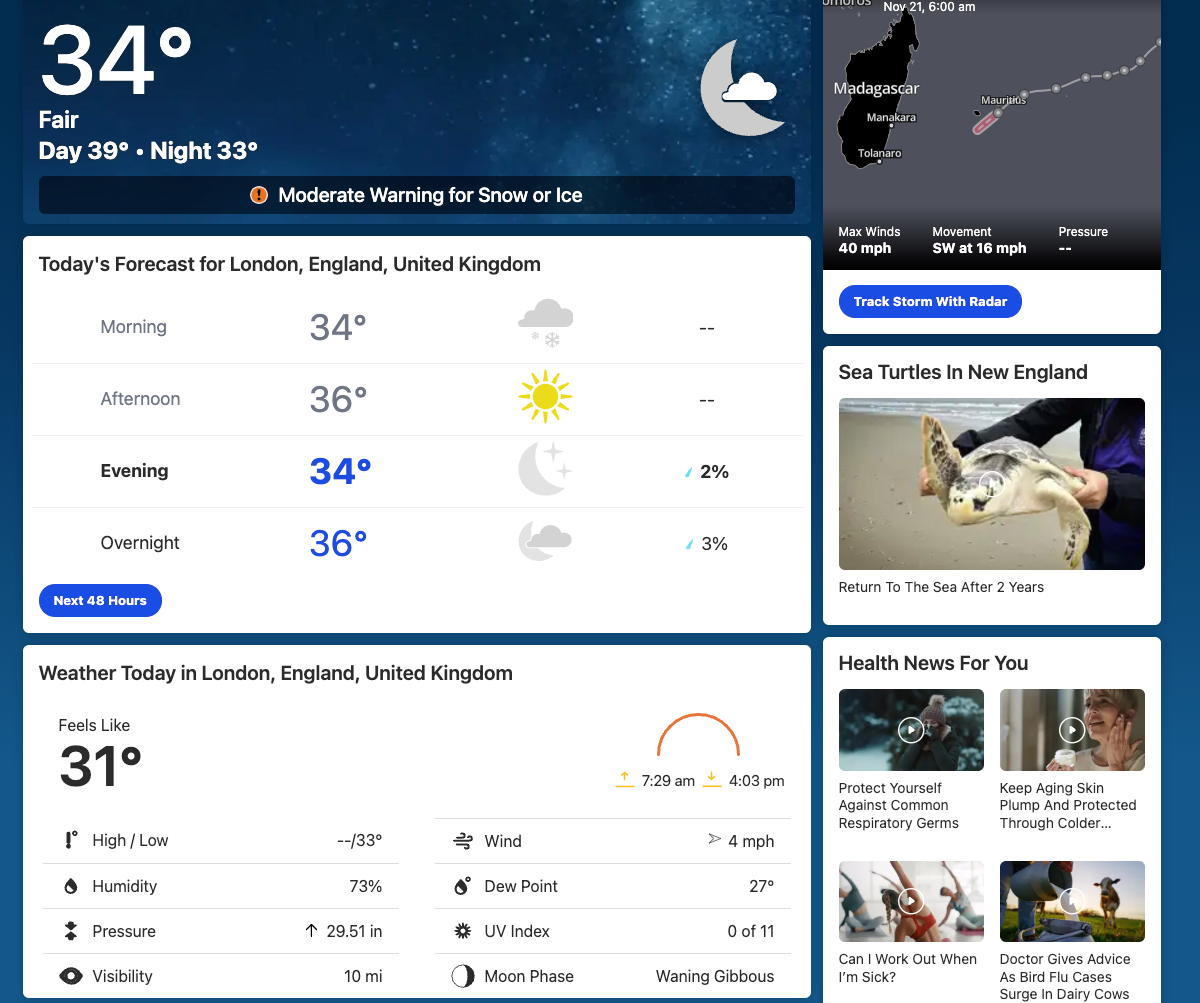

Unlike websites such as Amazon where you can simply modify the URL's search parameter (e.g. `?search=`), weather.com presents a unique challenge. The site generates dynamic and unique IDs for each city, making traditional URL manipulation techniques ineffective. To scrape weather data for any given city, you must simulate the actual user journey: visiting the homepage, interacting with the search bar, entering the city name, and selecting the appropriate result from the dropdown list. This multi-step interaction process is necessary because of how weather.com structures its dynamic content delivery (at this point, I urge to visit the website and visit a few city pages).

Fortunately, Firecrawl natively supports such interactions through the `actions` parameter. It accepts a list of dictionaries, where each dictionary represents one of the following interactions:

- Waiting for the page to load
- Clicking on an element
- Writing text in input fields
- Scrolling up/down
- Take a screenshot at the current state
- Scrape the current state of the webpage

Let's define the actions we need for weather.com:

In [61]:
actions = [
    {"type": "wait", "milliseconds": 3000},
    {"type": "click", "selector": 'input[id="LocationSearch_input"]'},
    {"type": "write", "text": "London"},
    {"type": "screenshot"},
    {"type": "wait", "milliseconds": 1000},
    {"type": "click", "selector": "button[data-testid='ctaButton']"},
    {"type": "wait", "milliseconds": 3000},
]

Let's examine how we choose the selectors, as this is the most technical aspect of the actions. Using browser developer tools, we inspect the webpage elements to find the appropriate selectors. For the search input field, we locate an element with the ID "LocationSearch_input". After entering a city name, we include a 3-second wait to allow the dropdown search results to appear. At this stage, we capture a screenshot for debugging to verify the text input was successful. 

The final step involves clicking the first matching result, which is identified by a button element with the `data-testid` attribute "ctaButton". Note that if you're implementing this in the future, these specific attribute names may have changed - you'll need to use browser developer tools to find the current correct selectors.

Now, let's define a Pydantic schema to guide the LLM:

In [69]:
class WeatherData(BaseModel):
    location: str = Field(description="The name of the city")
    temperature: str = Field(description="The current temperature in degrees Fahrenheit")
    temperature_high: str = Field(description="The high temperature for the day in degrees Fahrenheit")
    temperature_low: str = Field(description="The low temperature for the day in degrees Fahrenheit")
    humidity: str = Field(description="The current humidity as a percentage")
    pressure: str = Field(description="The current air pressure in inches of mercury")
    visibility: str = Field(description="The current visibility in miles")
    wind_speed: str = Field(description="The current wind speed in miles per hour")
    dew_point: str = Field(description="The current dew point in degrees Fahrenheit")
    uv_index: str = Field(description="The current UV index")
    moon_phase: str = Field(description="The current moon phase")

Finally, let's pass these objects to `scrape_url`:

In [70]:
url = "https://weather.com"

data = app.scrape_url(
    url,
    params={
        "formats": ["screenshot", "markdown", "extract"],
        "actions": actions,
        "extract": {
            "schema": WeatherData.model_json_schema(),
            "prompt": "Extract the following weather data from the weather.com page: temperature, temperature high, temperature low, humidity, pressure, visibility, wind speed, dew point, UV index, and moon phase",
        },
    },
)

The scraping only happens once all actions are performed. Let's see if it was successful by looking at the `extract` key:

In [71]:
data['extract']

{'location': 'London, England, United Kingdom',
 'temperature': '33°',
 'temperature_high': '39°',
 'temperature_low': '33°',
 'humidity': '79%',
 'pressure': '29.52in',
 'visibility': '10 mi',
 'wind_speed': '5 mph',
 'dew_point': '28°',
 'uv_index': '0 of 11',
 'moon_phase': 'Waning Gibbous'}

All details are accounted for! But, for illustration, we need to take a closer look at the response structure when using JS-based actions:

In [72]:
data.keys()

dict_keys(['markdown', 'screenshot', 'actions', 'metadata', 'extract'])

The response has a new actions key:

In [73]:
data['actions']

{'screenshots': ['https://service.firecrawl.dev/storage/v1/object/public/media/screenshot-16bf71d8-dcb5-47eb-9af4-5fa84195b91d.png'],
 'scrapes': []}

The actions array contained a single screenshot-generating action, which is reflected in the output above.

Let's look at the screenshot:

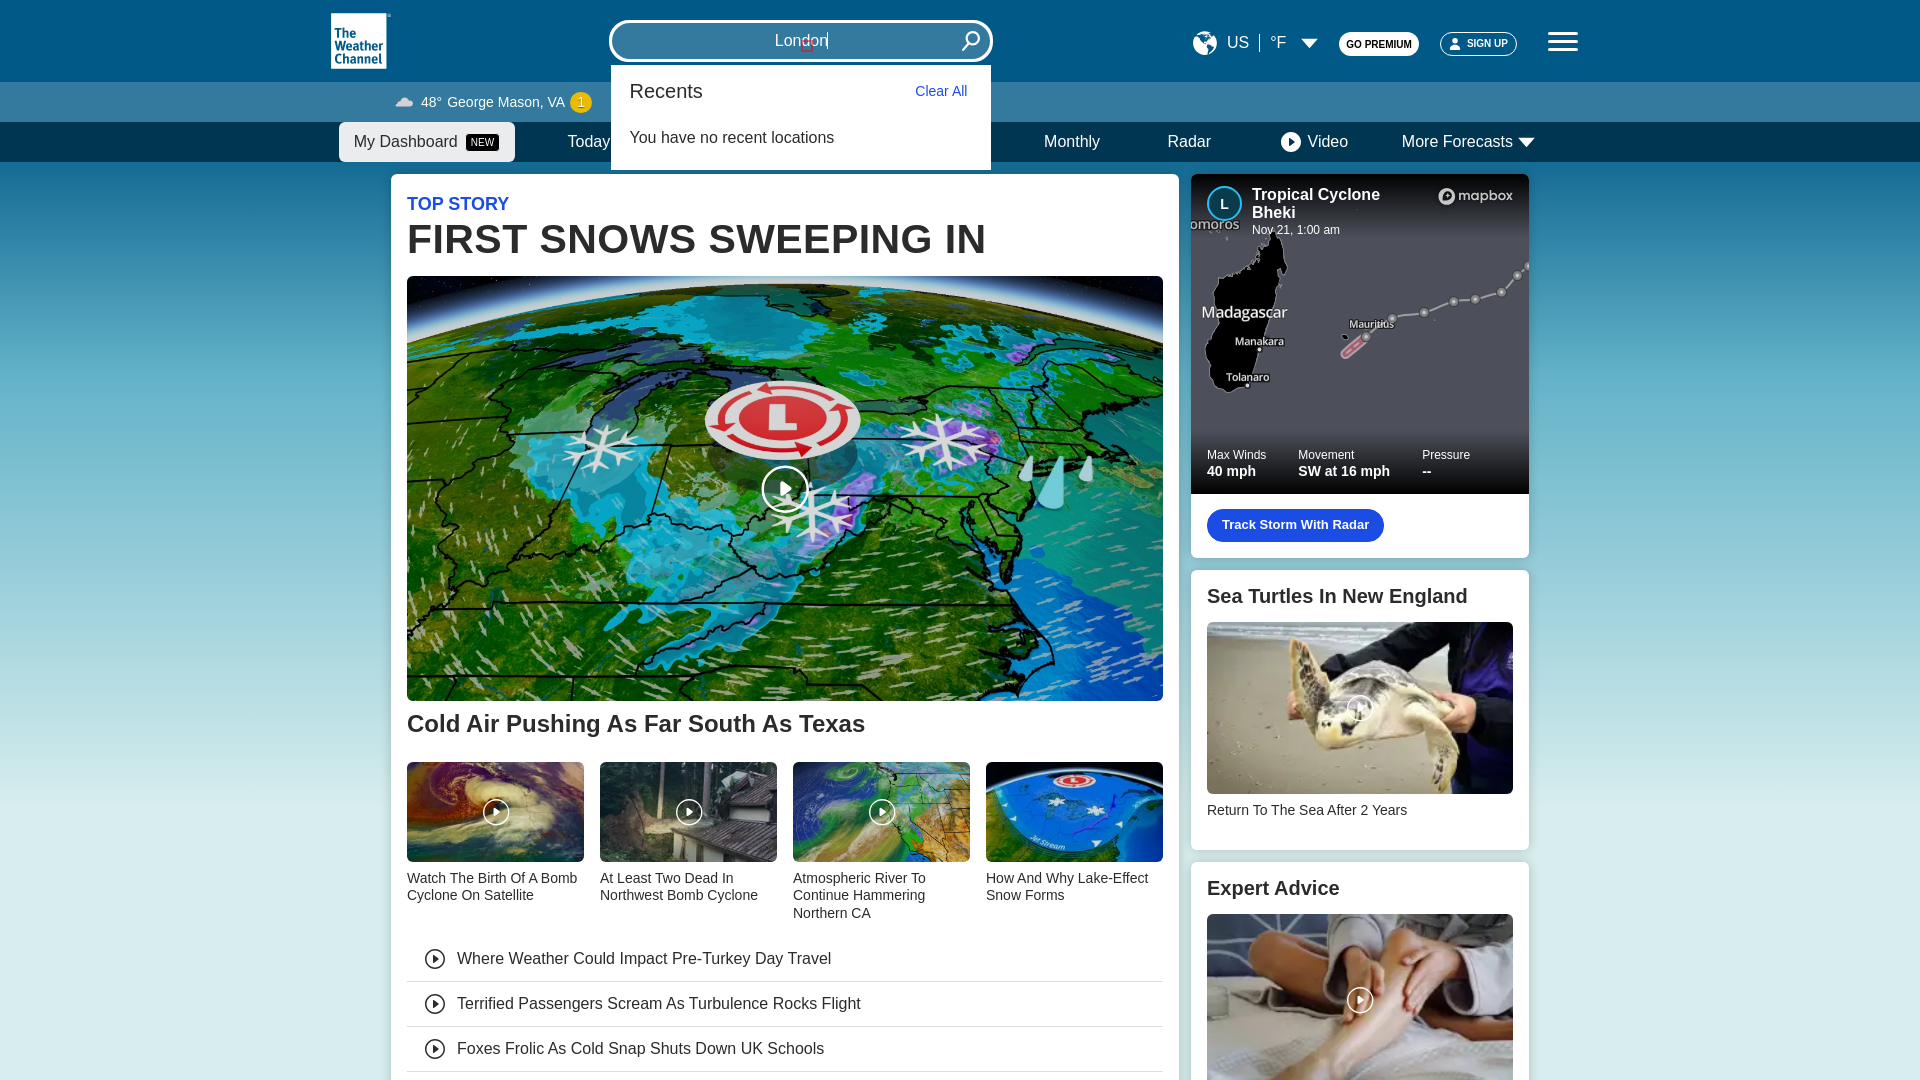

In [74]:
from IPython.display import Image

Image(data['actions']['screenshots'][0])

The image shows the stage where the scraper just typed the search query. 

Now, we have to convert this whole process into a function that works for any given city:

In [75]:
from pydantic import BaseModel, Field
from typing import Optional, Dict, Any


class WeatherData(BaseModel):
    location: str = Field(description="The name of the city")
    temperature: str = Field(
        description="The current temperature in degrees Fahrenheit"
    )
    temperature_high: str = Field(
        description="The high temperature for the day in degrees Fahrenheit"
    )
    temperature_low: str = Field(
        description="The low temperature for the day in degrees Fahrenheit"
    )
    humidity: str = Field(description="The current humidity as a percentage")
    pressure: str = Field(description="The current air pressure in inches of mercury")
    visibility: str = Field(description="The current visibility in miles")
    wind_speed: str = Field(description="The current wind speed in miles per hour")
    dew_point: str = Field(description="The current dew point in degrees Fahrenheit")
    uv_index: str = Field(description="The current UV index")
    moon_phase: str = Field(description="The current moon phase")


def scrape_weather_data(app: FirecrawlApp, city: str) -> Optional[WeatherData]:
    try:
        # Define the actions to search for the city
        actions = [
            {"type": "wait", "milliseconds": 3000},
            {"type": "click", "selector": 'input[id="LocationSearch_input"]'},
            {"type": "write", "text": city},
            {"type": "wait", "milliseconds": 1000},
            {"type": "click", "selector": "button[data-testid='ctaButton']"},
            {"type": "wait", "milliseconds": 3000},
        ]

        # Perform the scraping
        data = app.scrape_url(
            "https://weather.com",
            params={
                "formats": ["extract"],
                "actions": actions,
                "extract": {
                    "schema": WeatherData.model_json_schema(),
                    "prompt": "Extract the following weather data from the weather.com page: temperature, temperature high, temperature low, humidity, pressure, visibility, wind speed, dew point, UV index, and moon phase",
                },
            },
        )

        # Return the extracted weather data
        return WeatherData(**data["extract"])

    except Exception as e:
        print(f"Error scraping weather data for {city}: {str(e)}")
        return None

The code is the same but it is wrapped inside a function. Let's test it on various cities:

In [76]:
cities = ["Tashkent", "New York", "Tokyo", "Paris", "Istanbul"]
data_full = []

for city in cities:
    weather_data = scrape_weather_data(app, city)
    data_full.append(weather_data)

We can convert the data for all cities into a DataFrame now:

In [83]:
import pandas as pd

# Convert list of WeatherData objects into dictionaries
data_dicts = [city.model_dump() for city in data_full]

# Convert list of dictionaries into DataFrame
df = pd.DataFrame(data_dicts)

df.head()

,location,temperature,temperature_high,temperature_low,humidity,pressure,visibility,wind_speed,dew_point,uv_index,moon_phase
0,"Tashkent, Uzbekistan",48,54,41,81,30.30,2.5,2,43,0,Waning Gibbous
1,"New York City, NY",48°,49°,39°,93%,29.45 in,4 mi,10 mph,46°,0 of 11,Waning Gibbous
2,"Tokyo, Tokyo Prefecture, Japan",47°,61°,48°,95%,29.94 in,10 mi,1 mph,45°,0 of 11,Waning Gibbous
3,"Paris, France",34°,36°,30°,93%,29.42 in,2.4 mi,11 mph,33°,0 of 11,Waning Gibbous
4,"Istanbul, Türkiye",47°,67°,44°,79%,29.98 in,8 mi,4 mph,41°,0 of 11,Waning Gibbous


We have successfully scraped weather data from multiple cities using and organized it into a structured DataFrame. This demonstrates how we can efficiently collect and analyze data generated by dynamic websites for further analysis and monitoring.

## Conclusion

In this comprehensive guide, we've explored Firecrawl's `/scrape` endpoint and its powerful capabilities for modern web scraping. We covered:

- Basic scraping setup and configuration options
- Multiple output formats including HTML, markdown, and screenshots
- Structured data extraction using both natural language prompts and Pydantic schemas
- Batch operations for processing multiple URLs efficiently
- Advanced techniques for scraping JavaScript-heavy dynamic websites

Through practical examples like extracting news articles from the NY Times and weather data from weather.com, we've demonstrated how Firecrawl simplifies complex scraping tasks while providing flexible output formats suitable for data engineering and AI/ML pipelines.

The combination of LLM-powered extraction, structured schemas, and browser automation capabilities makes Firecrawl a versatile tool for gathering high-quality web data at scale, whether you're building training datasets, monitoring websites, or conducting research.